## 0. Libarary 불러오기 및 경로설정

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import time
import datetime
import albumentations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from PIL import Image
from copy import deepcopy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from pytz import timezone
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import lr_scheduler

from pytorch_pretrained_vit import ViT

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print('PyTorch version: {}'.format(torch.__version__))

PyTorch version: 1.7.1


In [5]:
# Set random seed
SEED = 2021
# random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [49]:
class cfg:
    train_dir = '/opt/ml/input/data/train'
    img_dir = f'{train_dir}/images'
    df_path = f'{train_dir}/train_with_label.csv'
    
    model_save_path = '/opt/ml/code/model'
    sumission_save_path = '/opt/ml/code/submission'
    
    test_dir = '/opt/ml/input/data/eval'
    submission_dir = f'{sumission_save_path}/{datetime.datetime.today().astimezone(timezone("Asia/Seoul")).strftime("%Y-%m-%d")}'

In [50]:
if not os.path.exists(cfg.submission_dir):
    os.mkdir(cfg.submission_dir)

In [8]:
## HYPER PARAMETER 정의
EPOCHS = 50
BATCH_SIZE = 100
LEARNING_RATE = 0.001
CLASS_NUM = 18
IMAGE_SIZE = 384
PATIENCE = 5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is using!')

cuda:0 is using!


## 1. Pretrained Model 불러오기

In [9]:
vit = ViT('B_16_imagenet1k', pretrained=True)
print('네트워크 필요 입력 채널 개수', vit.patch_embedding.weight.shape[1])
print('네트워크 출력 채널 개수 (예측 class type 개수)', vit.fc.weight.shape[0])
print(vit)

Loaded pretrained weights.
네트워크 필요 입력 채널 개수 3
네트워크 출력 채널 개수 (예측 class type 개수) 1000
ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_af

In [10]:
# target model의 출력 크기를 변경하여 줍니다.
vit.fc = torch.nn.Linear(in_features=768, out_features=CLASS_NUM, bias=True)

# 새롭게 넣은 네트워크 가중치를 xavier uniform으로 초기화
torch.nn.init.xavier_uniform_(vit.fc.weight)
stdv = 1.0/np.sqrt(768)
vit.fc.bias.data.uniform_(-stdv, stdv)

print('네트워크 출력 채널 개수 (예측 class type 개수)', vit.fc.weight.shape[0])

네트워크 출력 채널 개수 (예측 class type 개수) 18


In [11]:
for param in vit.parameters():
    param.requires_grad = False

In [12]:
for param in vit.fc.parameters():
    param.requires_grad = True

### requires_grad = False 적용 됐는지 확인

In [13]:
list(vit.patch_embedding.parameters())[0]

Parameter containing:
tensor([[[[ 1.2565e-02,  5.0151e-02,  5.6412e-02,  ...,  9.1647e-02,
            1.1258e-01,  1.2726e-01],
          [ 1.2852e-02,  1.4875e-02,  2.2059e-02,  ...,  8.7276e-02,
            4.2421e-02,  8.9284e-02],
          [ 1.8606e-02,  1.3768e-02, -2.5441e-03,  ...,  7.8996e-02,
            3.5360e-02,  3.8059e-02],
          ...,
          [-1.3499e-02, -3.9727e-03, -5.3725e-02,  ..., -5.8909e-02,
           -6.8349e-02,  1.9621e-02],
          [ 4.0168e-02, -4.4040e-02, -2.1628e-02,  ...,  1.2683e-02,
           -3.8754e-02,  8.5574e-02],
          [ 7.1434e-02,  8.2304e-02,  3.8617e-02,  ...,  1.0045e-01,
            1.2122e-01,  1.6293e-01]],

         [[-6.5743e-02, -4.0097e-02, -4.2712e-02,  ..., -6.1647e-02,
           -2.6194e-02, -2.0021e-02],
          [-6.5871e-03, -9.1357e-03, -5.8212e-03,  ..., -3.3783e-02,
           -4.6455e-02, -2.4184e-03],
          [ 4.9546e-02,  3.6097e-02,  1.6419e-02,  ..., -3.5878e-02,
           -4.1035e-02, -3.4361e-02]

In [14]:
list(vit.fc.parameters())[0]

Parameter containing:
tensor([[-0.0871,  0.0813,  0.0376,  ..., -0.0113,  0.0165, -0.0697],
        [-0.0657,  0.0575,  0.0863,  ...,  0.0762,  0.0082,  0.0395],
        [ 0.0582, -0.0868, -0.0620,  ..., -0.0386,  0.0801,  0.0522],
        ...,
        [-0.0777,  0.0180,  0.0338,  ..., -0.0216,  0.0589, -0.0549],
        [-0.0488,  0.0436, -0.0851,  ...,  0.0524, -0.0657,  0.0541],
        [-0.0510, -0.0265,  0.0577,  ..., -0.0110, -0.0380, -0.0638]],
       requires_grad=True)

## 2. Train Dataset 정의

In [15]:
class MyDataset(Dataset):
    def __init__(self, df, transform):
        self.img_paths = df['image_path']
        self.transform = transform
        self.y = df['target']

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.img_paths.iloc[idx]))
        label = self.y.iloc[idx]

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image, torch.tensor(label)

In [16]:
df = pd.read_csv(os.path.join(cfg.train_dir, 'train_with_label.csv'))

In [17]:
train_df, valid_df = train_test_split(df, test_size=0.3, stratify=df['target'], 
                                      shuffle=True, random_state=2021)
train_df.shape, valid_df.shape

((13230, 7), (5670, 7))

# train_df 이미지의 pixel 값의 mean & std

images_info = {'height': [], 'width': [], 'means': [], 'stds': []}
for i, image_path in enumerate(tqdm(train_df.image_path)):
    img = np.array(Image.open(image_path))
    h, w, _ = img.shape
    images_info['height'].append(h)
    images_info['width'].append(w)
    images_info['means'].append(img.mean(axis=(0, 1)))
    images_info['stds'].append(img.std(axis=(0, 1)))

print('Train Data')

print(f'Minimum height for dataset is {np.min(images_info["height"])}')
print(f'Maximum height for dataset is {np.max(images_info["height"])}')
print(f'Average height for dataset is {int(np.mean(images_info["height"]))}')
print(f'Minimum width for dataset is {np.min(images_info["width"])}')
print(f'Maximum width for dataset is {np.max(images_info["width"])}')
print(f'Average width for dataset is {int(np.mean(images_info["width"]))}')

print(f'RGB Mean: {np.mean(images_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(images_info["stds"], axis=0) / 255.}')

`!pip install -U albumentations==0.5.2`

In [18]:
mean_list = [0.56074416, 0.52454219, 0.50188343]
std_list = [0.23304677, 0.24291714, 0.24565602]

In [19]:
train_transform = albumentations.Compose([
    albumentations.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1.0),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ShiftScaleRotate(p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    albumentations.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    albumentations.GaussNoise(p=0.5),
    albumentations.Normalize(mean=mean_list, std=std_list, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0),
])
valid_transform = albumentations.Compose([
    albumentations.Resize(IMAGE_SIZE, IMAGE_SIZE),
    albumentations.Normalize(mean=mean_list, std=std_list, max_pixel_value=255.0, p=1.0),
    ToTensorV2(p=1.0),
])

In [20]:
train_dataset = MyDataset(train_df, train_transform)
valid_dataset = MyDataset(valid_df, valid_transform)
len(train_dataset), len(valid_dataset)

(13230, 5670)

## 3. Train DataLoader 정의

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=2)

## 4. Criterion & Optimizer & lr_scheduler & EarlyStopping 정의

In [22]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_f1_score_max = -np.Inf

    def __call__(self, val_f1_score, model):

        score = val_f1_score

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_f1_score, model)
            self.counter = 0

    def save_checkpoint(self, val_f1_score, model):
        '''Saves model when validation f1_score increase.'''
        if self.verbose:
            print(f'Validation f1_score increased ({self.val_f1_score_max:.6f} --> {val_f1_score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'{os.path.join(cfg.model_save_path, "VIT")}/checkpoint.pt')
        self.val_f1_score_max = val_f1_score

In [23]:
model = vit.to(device)

# weight = torch.tensor(len(train_df) // train_df.target.value_counts()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
earlystop = EarlyStopping(patience=PATIENCE, verbose = True)

## 5. Train

In [24]:
start = time.time()

train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

best_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    # Train phase
    model.train()
    
    train_running_loss = 0
    train_running_acc = 0
    train_running_epoch_f1 = 0
    
    pbar = tqdm(train_loader)
    for X_batch, y_batch in pbar:
        pbar.set_description(f'Epoch {epoch}/{EPOCHS} | loss : {train_running_loss:.4f} | F1_score : {train_running_epoch_f1:.4f}')
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.cuda.LongTensor)
        
        optimizer.zero_grad()
        
        y_pred = model.forward(X_batch)
        _, preds = torch.max(y_pred, 1)
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item() / len(y_batch)
        train_running_acc += torch.sum(preds == y_batch.data) / len(y_batch)
        train_running_epoch_f1 += f1_score(preds.cpu().numpy(), 
                                           y_batch.cpu().numpy(), average='macro')
        
    exp_lr_scheduler.step()
    
    train_epoch_loss = train_running_loss / len(train_loader)
    train_epoch_acc = train_running_acc / len(train_loader)
    train_epoch_f1 = train_running_epoch_f1 / len(train_loader)
    
    train_acc_history.append(train_epoch_acc)
    train_loss_history.append(train_epoch_loss)
    
    print(f'Train Loss : {train_epoch_loss:.4f}, Accuracy : {train_epoch_acc:.4f}, F1_score : {train_epoch_f1:.4f}')
    
    # Validation pahse
    model.eval()
    
    valid_running_loss = 0
    valid_running_acc = 0
    valid_running_epoch_f1 = 0
    with torch.no_grad():
        pbar = tqdm(valid_loader)
        for X_batch, y_batch in pbar:
            pbar.set_description(f'Epoch {epoch}/{EPOCHS} | loss : {valid_running_loss:.4f} | F1_score : {valid_running_epoch_f1:.4f}')
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.cuda.LongTensor)
            
            y_pred = model.forward(X_batch)
            _, preds = torch.max(y_pred, 1)
            loss = criterion(y_pred, y_batch)
            
            valid_running_loss += loss.item() / len(y_batch)
            valid_running_acc += torch.sum(preds == y_batch.data) / len(y_batch)
            valid_running_epoch_f1 += f1_score(preds.cpu().numpy(), 
                                           y_batch.cpu().numpy(), average='macro')
            
    valid_epoch_loss = valid_running_loss / len(valid_loader)
    valid_epoch_acc = valid_running_acc / len(valid_loader)
    valid_epoch_f1 = valid_running_epoch_f1 / len(valid_loader)
    
    earlystop(valid_epoch_f1, model)
    
    print(f'Validation Loss : {valid_epoch_loss:.4f}, Accuracy : {valid_epoch_acc:.4f}, F1_score : {valid_epoch_f1:.4f}')   
    
    if valid_epoch_f1 > best_f1:
        best_f1 = valid_epoch_f1
    
    val_acc_history.append(valid_epoch_acc)
    val_loss_history.append(valid_epoch_loss)
    
    if earlystop.early_stop:
        print('Early stopping')
        model.load_state_dict(torch.load(f'{os.path.join(cfg.model_save_path, "VIT")}/checkpoint.pt'))
        break

print('Best Validation F1_score: {:.4f}'.format(best_f1))
torch.save(model.state_dict(),
           f'{os.path.join(cfg.model_save_path, "VIT")}/best_model_{best_f1:.4f}.pt')
print('학습 종료!')
end = time.time()
print(f'학습 총 걸린 시간 : {end - start:.2f}')

Epoch 1/50 | loss : 1.7552 | F1_score : 52.1229: 100%|██████████| 133/133 [02:49<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0134, Accuracy : 0.5647, F1_score : 0.3965


Epoch 1/50 | loss : 0.4646 | F1_score : 31.1935: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (-inf --> 0.554410).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0084, Accuracy : 0.7219, F1_score : 0.5544


Epoch 2/50 | loss : 0.9944 | F1_score : 78.9918: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0077, Accuracy : 0.7527, F1_score : 0.5976


Epoch 2/50 | loss : 0.3588 | F1_score : 34.9977: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.554410 --> 0.625091).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0064, Accuracy : 0.7890, F1_score : 0.6251


Epoch 3/50 | loss : 0.8169 | F1_score : 87.9329: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0063, Accuracy : 0.7987, F1_score : 0.6664


Epoch 3/50 | loss : 0.3266 | F1_score : 36.2787: 100%|██████████| 57/57 [01:07<00:00,  1.19s/it]


Validation f1_score increased (0.625091 --> 0.648840).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0059, Accuracy : 0.8088, F1_score : 0.6488


Epoch 4/50 | loss : 0.7411 | F1_score : 90.9676: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0057, Accuracy : 0.8140, F1_score : 0.6912


Epoch 4/50 | loss : 0.2926 | F1_score : 38.8923: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.648840 --> 0.694572).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0053, Accuracy : 0.8263, F1_score : 0.6946


Epoch 5/50 | loss : 0.6958 | F1_score : 93.5778: 100%|██████████| 133/133 [02:49<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0054, Accuracy : 0.8203, F1_score : 0.7093


Epoch 5/50 | loss : 0.2852 | F1_score : 38.2954: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0051, Accuracy : 0.8245, F1_score : 0.6842


Epoch 6/50 | loss : 0.6417 | F1_score : 94.7303: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0050, Accuracy : 0.8350, F1_score : 0.7166


Epoch 6/50 | loss : 0.2692 | F1_score : 38.4003: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0049, Accuracy : 0.8319, F1_score : 0.6822


Epoch 7/50 | loss : 0.6200 | F1_score : 96.9841: 100%|██████████| 133/133 [02:48<00:00,  1.26s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0049, Accuracy : 0.8412, F1_score : 0.7339


Epoch 7/50 | loss : 0.2604 | F1_score : 38.9921: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.694572 --> 0.699812).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0046, Accuracy : 0.8345, F1_score : 0.6998


Epoch 8/50 | loss : 0.5811 | F1_score : 100.2067: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0045, Accuracy : 0.8526, F1_score : 0.7593


Epoch 8/50 | loss : 0.2502 | F1_score : 39.1528: 100%|██████████| 57/57 [01:08<00:00,  1.19s/it]


Validation f1_score increased (0.699812 --> 0.700745).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0045, Accuracy : 0.8419, F1_score : 0.7007


Epoch 9/50 | loss : 0.5831 | F1_score : 99.1084: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0045, Accuracy : 0.8538, F1_score : 0.7523


Epoch 9/50 | loss : 0.2505 | F1_score : 39.0250: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0045, Accuracy : 0.8412, F1_score : 0.6961


Epoch 10/50 | loss : 0.5703 | F1_score : 99.4705: 100%|██████████| 133/133 [02:48<00:00,  1.26s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0044, Accuracy : 0.8554, F1_score : 0.7536


Epoch 10/50 | loss : 0.2484 | F1_score : 39.1079: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0045, Accuracy : 0.8406, F1_score : 0.6964


Epoch 11/50 | loss : 0.5806 | F1_score : 99.0381: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0045, Accuracy : 0.8531, F1_score : 0.7510


Epoch 11/50 | loss : 0.2452 | F1_score : 39.3474: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.700745 --> 0.700801).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0045, Accuracy : 0.8435, F1_score : 0.7008


Epoch 12/50 | loss : 0.5689 | F1_score : 100.0183: 100%|██████████| 133/133 [02:48<00:00,  1.26s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0044, Accuracy : 0.8579, F1_score : 0.7592


Epoch 12/50 | loss : 0.2464 | F1_score : 38.5133: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0044, Accuracy : 0.8431, F1_score : 0.6895


Epoch 13/50 | loss : 0.5602 | F1_score : 99.2823: 100%|██████████| 133/133 [02:48<00:00,  1.26s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8567, F1_score : 0.7524


Epoch 13/50 | loss : 0.2457 | F1_score : 38.9835: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0044, Accuracy : 0.8427, F1_score : 0.6977


Epoch 14/50 | loss : 0.5654 | F1_score : 99.8861: 100%|██████████| 133/133 [02:47<00:00,  1.26s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0044, Accuracy : 0.8531, F1_score : 0.7573


Epoch 14/50 | loss : 0.2438 | F1_score : 39.3470: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.700801 --> 0.705229).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0044, Accuracy : 0.8468, F1_score : 0.7052


Epoch 15/50 | loss : 0.5601 | F1_score : 99.9362: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8577, F1_score : 0.7574


Epoch 15/50 | loss : 0.2434 | F1_score : 39.1012: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0044, Accuracy : 0.8452, F1_score : 0.6992


Epoch 16/50 | loss : 0.5639 | F1_score : 100.1781: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8557, F1_score : 0.7593


Epoch 16/50 | loss : 0.2448 | F1_score : 39.4777: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.705229 --> 0.705884).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0044, Accuracy : 0.8451, F1_score : 0.7059


Epoch 17/50 | loss : 0.5617 | F1_score : 100.5865: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8578, F1_score : 0.7617


Epoch 17/50 | loss : 0.2436 | F1_score : 38.8625: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0044, Accuracy : 0.8452, F1_score : 0.6950


Epoch 18/50 | loss : 0.5609 | F1_score : 100.6124: 100%|██████████| 133/133 [02:48<00:00,  1.26s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8580, F1_score : 0.7634


Epoch 18/50 | loss : 0.2445 | F1_score : 39.0279: 100%|██████████| 57/57 [01:07<00:00,  1.19s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0044, Accuracy : 0.8453, F1_score : 0.6968


Epoch 19/50 | loss : 0.5567 | F1_score : 100.1400: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8553, F1_score : 0.7582


Epoch 19/50 | loss : 0.2433 | F1_score : 39.8908: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.705884 --> 0.709232).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0044, Accuracy : 0.8452, F1_score : 0.7092


Epoch 20/50 | loss : 0.5589 | F1_score : 100.6183: 100%|██████████| 133/133 [02:49<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8585, F1_score : 0.7629


Epoch 20/50 | loss : 0.2434 | F1_score : 39.0522: 100%|██████████| 57/57 [01:08<00:00,  1.19s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0044, Accuracy : 0.8460, F1_score : 0.6980


Epoch 21/50 | loss : 0.5612 | F1_score : 99.7499: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8558, F1_score : 0.7552


Epoch 21/50 | loss : 0.2429 | F1_score : 39.2694: 100%|██████████| 57/57 [01:07<00:00,  1.19s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0044, Accuracy : 0.8453, F1_score : 0.7007


Epoch 22/50 | loss : 0.5597 | F1_score : 99.9855: 100%|██████████| 133/133 [02:49<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8551, F1_score : 0.7571


Epoch 22/50 | loss : 0.2434 | F1_score : 39.6484: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.709232 --> 0.709820).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0044, Accuracy : 0.8455, F1_score : 0.7098


Epoch 23/50 | loss : 0.5564 | F1_score : 100.9978: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0042, Accuracy : 0.8594, F1_score : 0.7666


Epoch 23/50 | loss : 0.2426 | F1_score : 39.8115: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]


Validation f1_score increased (0.709820 --> 0.710353).  Saving model ...


  0%|          | 0/133 [00:00<?, ?it/s]

Validation Loss : 0.0044, Accuracy : 0.8451, F1_score : 0.7104


Epoch 24/50 | loss : 0.5529 | F1_score : 102.1019: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8607, F1_score : 0.7725


Epoch 24/50 | loss : 0.2436 | F1_score : 39.4731: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 7
Validation Loss : 0.0044, Accuracy : 0.8455, F1_score : 0.7040


Epoch 25/50 | loss : 0.5695 | F1_score : 100.0440: 100%|██████████| 133/133 [02:48<00:00,  1.26s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0044, Accuracy : 0.8534, F1_score : 0.7574


Epoch 25/50 | loss : 0.2442 | F1_score : 38.9466: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 7
Validation Loss : 0.0044, Accuracy : 0.8458, F1_score : 0.6988


Epoch 26/50 | loss : 0.5642 | F1_score : 99.6678: 100%|██████████| 133/133 [02:48<00:00,  1.27s/it]
  0%|          | 0/57 [00:00<?, ?it/s]

Train Loss : 0.0043, Accuracy : 0.8517, F1_score : 0.7546


Epoch 26/50 | loss : 0.2423 | F1_score : 39.6726: 100%|██████████| 57/57 [01:08<00:00,  1.20s/it]
  0%|          | 0/133 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 7
Validation Loss : 0.0044, Accuracy : 0.8450, F1_score : 0.7064


Epoch 27/50 | loss : 0.4275 | F1_score : 74.2567:  74%|███████▎  | 98/133 [02:06<00:45,  1.29s/it]


KeyboardInterrupt: 

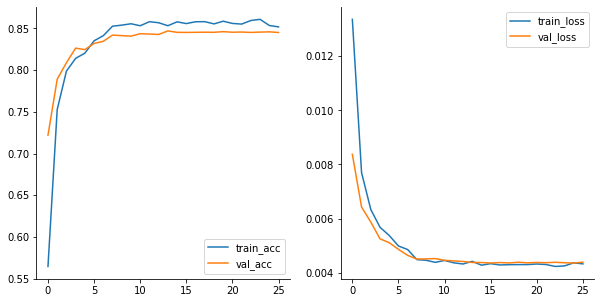

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_acc_history, label='train_acc')
axes[0].plot(val_acc_history, label='val_acc')
axes[1].plot(train_loss_history, label='train_loss')
axes[1].plot(val_loss_history, label='val_loss')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    
plt.show()

## 6. Inference

## 6.1 Test Dataset 정의

In [43]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = np.array(Image.open(self.img_paths[index]))

        if self.transform:
            image = self.transform(image=image)
            image = image['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [44]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(cfg.test_dir, 'info.csv'))
image_dir = os.path.join(cfg.test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

dataset = TestDataset(image_paths, valid_transform)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
best_model_path = [file for file in glob.glob(os.path.join(cfg.model_save_path, 'VIT/*')) 
                   if 'checkpoint' in file][0]
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(cfg.submission_dir, 'submission_{}.csv'.format(
    datetime.datetime.today().astimezone(timezone("Asia/Seoul")).strftime('%Y-%m-%d_%H:%M:%S'))), 
                  index=False)
print('test inference is done!')

100%|██████████| 126/126 [02:29<00:00,  1.18s/it]

test inference is done!


In [48]:
cfg.sumission_save_path

'/opt/ml/code/submission'

In [46]:
cfg.sumission_save_pathtimm

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f21725f5040>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


In [47]:
all_vit_models = timm.list_models('*vit*')
all_vit_models

['convit_base',
 'convit_small',
 'convit_tiny',
 'levit_128',
 'levit_128s',
 'levit_192',
 'levit_256',
 'levit_384',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_large_r50_s32_224',
 'vit_large_r50_s32_224_in21k',
 'vit_large_r50_s32_384',
 'vit_small_patch16_224',
 'vit_small_patch16_224_in21k',
 'vit_small_patch16_384',
 'vit_small_patch32_224',
 'vit_small_patch32_224_in21k',
 'vit_sma